### Import library

In [75]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt

In [76]:
female_df = pd.read_pickle('preprocessed_data/female_self_data.pkl')
male_df = pd.read_pickle('preprocessed_data/male_self_data.pkl')
match_df = pd.read_pickle('preprocessed_data/match_data.pkl')

### Implement the model
1. According to personal features, grouping the people
2. Analysis the preferance for that group of people
3. For test data, classify the person according to the cluster results
4. Using perferance in step 2 to justify whether the date could success

#### Preproccessing

In [77]:
female_df.drop(labels=['race', 'field'], axis=1)
male_df.drop(labels=['race', 'field'], axis=1)

# divide the data into training and test part
female_train, female_test = train_test_split(female_df, test_size=0.1, random_state=0)
# male_train, male_test = train_test_split(male_df, test_size=0.1, random_state=0)

### K-means

In [78]:
#Remove categorical values
# features = female_train.drop(labels=['race', 'field'], axis=1)
n_features = len(female_train.columns)
std_scaler = StandardScaler()
normalized_features = std_scaler.fit_transform(female_train)
min_max_scaler = MinMaxScaler()
normalized_features = min_max_scaler.fit_transform(normalized_features)
print(normalized_features.shape)

(246, 28)


In [79]:
nmf_model = NMF(n_components=3, init='random', random_state=0)  # 3
W = nmf_model.fit_transform(normalized_features)
H = nmf_model.components_
print(W.shape)
print(H.shape)

(246, 3)
(3, 28)


d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarn

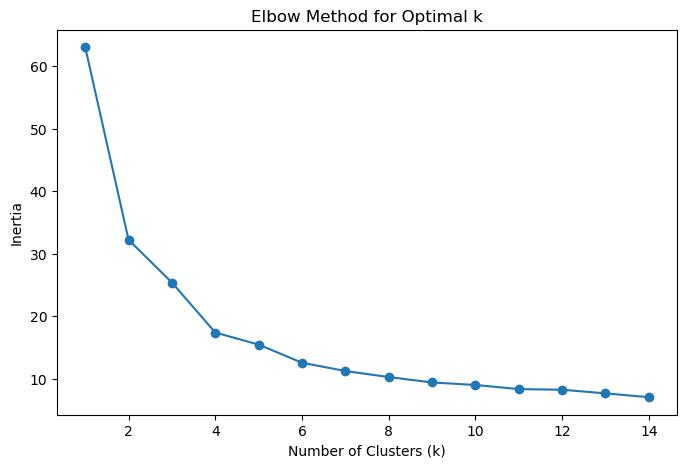

In [80]:
# use elbow method
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    # kmeans.fit(normalized_features)
    kmeans.fit(W)
    inertia.append(kmeans.inertia_)

# 绘制肘图
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [81]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(W)

# get the result labels
print(len(kmeans.labels_))
female_train['cluster'] = kmeans.labels_

246


d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Select the correspoding male for each group of female

In [82]:
# A dictionary that stores training data for each group
dic_X = {}
dic_y = {}

for i in range(k):
    dic_X[i] = pd.DataFrame(columns=male_df.columns)
    dic_y[i] = []

    female_group = female_train[female_train['cluster'] == i]
    for index, row in female_group.iterrows():
        male_group = match_df.loc[match_df['female_id'] == index]
        # print(male_group)
        dic_X[i] = pd.concat([dic_X[i], male_df.loc[male_group['male_id']]], ignore_index=True)
        dic_y[i].extend(male_group['match'].tolist())

print(dic_X.keys())
print(dic_X[0].shape)
# print(dic_X[0].iloc[0])
print(len(dic_y[0]))
print(dic_y[0])

C:\Users\nemuru\AppData\Local\Temp\ipykernel_13704\4187860867.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dic_X[i] = pd.concat([dic_X[i], male_df.loc[male_group['male_id']]], ignore_index=True)
C:\Users\nemuru\AppData\Local\Temp\ipykernel_13704\4187860867.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dic_X[i] = pd.concat([dic_X[i], male_df.loc[male_group['male_id']]], ignore_index=True)
C:\Users\nemuru\AppData\Local\Temp\ipykernel_13704\4187860867.py:13: FutureWarning: The behavi

dict_keys([0, 1, 2, 3])
(1066, 28)
1066
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

C:\Users\nemuru\AppData\Local\Temp\ipykernel_13704\4187860867.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dic_X[i] = pd.concat([dic_X[i], male_df.loc[male_group['male_id']]], ignore_index=True)


### Classification for every label

In [83]:
# baseline
dclf = DummyClassifier(strategy='most_frequent', random_state=0)

# build the pipeline for baseline
pipeline_baseline = Pipeline([
    ('standard_scaler', StandardScaler()),  # standardize
    ('minmax_scaler', MinMaxScaler()),      # normalize
    ('baseline', dclf)         # random guessing baseline
])

baseline_models = {}
for i in range(k):
    baseline_models[i] = pipeline_baseline.fit(dic_X[i], dic_y[i]) # train the model

In [84]:
# decision tree
pipeline_dt = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=0))  # dt
])

# hyper-parameters grid
param_grid_dt = {
    'dt__max_depth': [None, 10, 20, 30, 40],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

In [85]:
# random forest
pipeline_rmforest = Pipeline([
    ('scaler', StandardScaler()),                    # standardize
    ('rf', RandomForestClassifier(random_state=42))  # random forest
])
# pipeline_rmforest = ImbPipeline([
#     ('smote', SMOTE(random_state=42)),               # SMOTE 进行过采样
#     ('scaler', StandardScaler()),                    # standardize
#     ('rf', RandomForestClassifier(random_state=42))  # random forest
# ])

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [86]:
# SVM
pipeline_svm = ImbPipeline([
    ('smote', SMOTE(random_state=42)),      # SMOTE 进行过采样
    ('standard_scaler', StandardScaler()),  # standardize
    ('minmax_scaler', MinMaxScaler()),      # normalize
    ('svm', SVC(random_state=42))           # svm
])

# hyper-parameters grid
param_grid_svm = {
    'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}
# param_grid = {
#     'svm__C': [0.1, 1, 10],
#     'svm__kernel': ['linear', 'rbf'],
#     'svm__gamma': ['scale', 'auto']
# }

In [87]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
nested_scores = np.zeros(k)

models = {}
for i in range(k):
    # using grid search and cross validation
    models[i] = GridSearchCV(pipeline_rmforest, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
    models[i].fit(dic_X[i], dic_y[i]) # train the model

    nested_score = cross_val_score(models[i], X=dic_X[i], y=dic_y[i], cv=outer_cv)
    nested_scores[i] = nested_score.mean()

    # output the best parameter and score
    print("Best Parameter:", models[i].best_params_)
    print("Best Score:", models[i].best_score_)
    print("Nested Score:", nested_score.mean())

Best Parameter: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Score: 0.7842218419551578
Nested Score: 0.7823790092580405
Best Parameter: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Score: 0.8509284794999081
Nested Score: 0.8387387387387388
Best Parameter: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Best Score: 0.8282881664059527
Nested Score: 0.8282839386124383
Best Parameter: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Score: 0.8242681047765794
Nested Score: 0.8242616846430405


### Test the models

In [88]:
#Remove categorical values
# test_features = female_test.drop(labels=['race', 'field'], axis=1)
n_test_features = len(female_test.columns)
normalized_test_features = std_scaler.fit_transform(female_test)
normalized_test_features = min_max_scaler.fit_transform(normalized_test_features)
print(normalized_test_features.shape)

(28, 28)


In [89]:
W_test = nmf_model.fit_transform(normalized_test_features)
predictions = kmeans.predict(W_test)
print(predictions.shape)

female_test['cluster'] = predictions
# print(female_test['cluster'])

(28,)


d:\Programming\anaconda3\envs\esl_env\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [90]:
base_total = 0
base_true_positive = 0
# base_true_positive = []
for index, row in female_test.iterrows():
    group_num = row['cluster']
    male_id_match = match_df.loc[match_df['female_id'] == index]
    # print(male_id_match.shape)
    male_test = male_df.loc[male_id_match['male_id']]

    male_predictions = baseline_models[group_num].predict(male_test)
    base_total += male_id_match.shape[0]
    base_true_positive += accuracy_score(male_id_match['match'].tolist(), male_predictions)

    # score = baseline_models[group_num].score(male_test, male_id_match['match'].tolist())
    # print(score)
    # base_true_positive.append(score)
    

# predict the baseline model on the test dataset
accuracy = base_true_positive / base_total
# print(len(base_true_positive))
# accuracy = base_true_positive.mean()
print("Accuracy of the model:", accuracy)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy of the model: 0.05336099008728013


In [91]:
total = 0
true_positive = 0
for index, row in female_test.iterrows():
    group_num = row['cluster']
    male_id_match = match_df.loc[match_df['female_id'] == index]
    # print(male_id_match.shape)
    male_test = male_df.loc[male_id_match['male_id']]

    male_predictions = models[group_num].predict(male_test)
    # print(male_predictions.shape)
    # print(len(male_id_match['match'].tolist()))
    total += male_id_match.shape[0]
    true_positive += accuracy_score(male_id_match['match'].tolist(), male_predictions)

    # print(male_id_match['match'].tolist())
    # print(male_predictions)
    if not (male_predictions == 0).all().any():
        print(male_id_match['match'].tolist())
        print(male_predictions)
    

# predict the model on the test dataset
accuracy = true_positive / total
print("Accuracy of the model:", accuracy)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
[0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[0 0 0 1 0 0 0 0 1 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1 0 0 1 0 0 1 0 0 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
[0 0 0 1 0 0 0 0 0 0]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1]
[0 0 0 1 0 0 0 0 1 0]
Accuracy of the model: 0.05433898519730458


In [92]:
# record the results
